# **Imports**

In [72]:
import glob
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import rasterio
from rasterio.plot import show

import json
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from utils_dataloaders import *
from utils_training import *

##### set dataframe display options 
# show decimal format (not scientific notation)
pd.options.display.float_format = '{:.4f}'.format

# display all columns
pd.set_option('display.max_columns', None)

# **Data**

In [3]:

patches_geojson = [r'../data/howevalley/hv_patches_256_50.geojson', 
                   r'../data/sonora/sonora_patches_256_50.geojson', 
                   r'../data/warren/patches_256_50.geojson']

labels_path = glob.glob(r'../data/warren/*labels.csv')[0]
areas_path = glob.glob(r'../data/warren/*areas.csv')[0]

hardin_labels_path = glob.glob(r'../data/hardin/*labels.csv')[0]
hardin_areas_path = glob.glob(r'../data/hardin/*areas.csv')[0]

In [80]:
hardin_patches_geojson = r'../models/patches/hardin_patches_test.geojson'

gdf_hardin = gpd.read_file(hardin_patches_geojson)


gdf_hardin.shape

(1536, 2)

In [4]:
all_patches_path = r'../data/all_patches.geojson'

gdf = gpd.read_file(patches_geojson[0])
for p in patches_geojson[1:]:
    gdf2 = gpd.read_file(p)
    gdf = pd.concat([gdf, gdf2])

gdf.to_file(all_patches_path, driver='GeoJSON')

patch_ids = gdf['patch_id'].to_list()

In [5]:
all_counts_path = r'../data/all_counts.csv'

df_counts = pd.read_csv(labels_path)
df_counts = pd.concat([df_counts, pd.read_csv(hardin_labels_path)])

# df_counts.to_csv(all_counts_path, index=False)
counts = df_counts.iloc[:, 1:].sum(axis=0)
counts = pd.DataFrame(counts)

In [6]:
all_areas_path = r'../data/all_areas.csv'

df_areas = pd.read_csv(areas_path)
df_areas = pd.concat([df_areas, pd.read_csv(hardin_areas_path)])

# df_areas.to_csv(all_areas_path, index=False)

df_areas_longform = df_areas.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')

In [21]:
# path to JSON metadata
geo_meta_path = r'../data/warren/geology.json'

##### create custom color map from GeoTIFF metadata JSON
# NOTE: these are standard colors from Kentucky Geological Survey
with open(geo_meta_path, 'r') as meta:
    geo_meta = json.load(meta)

colors = {'af1': '#636566', 
          'Qal': '#fdf5a4', 
          'Qaf': '#ffa1db', 
          'Qat': '#f9e465', 
          'Qc': '#d6c9a7', 
          'Qca': '#c49d83', 
          'Qr': '#b0acd6'}

cmap = ListedColormap([colors[symbol] for symbol in geo_meta.keys()])


In [77]:
df_hardin = pd.read_csv(hardin_labels_path)
hardin_ids = df_hardin['patch_id'].to_list()

# **Modalities**

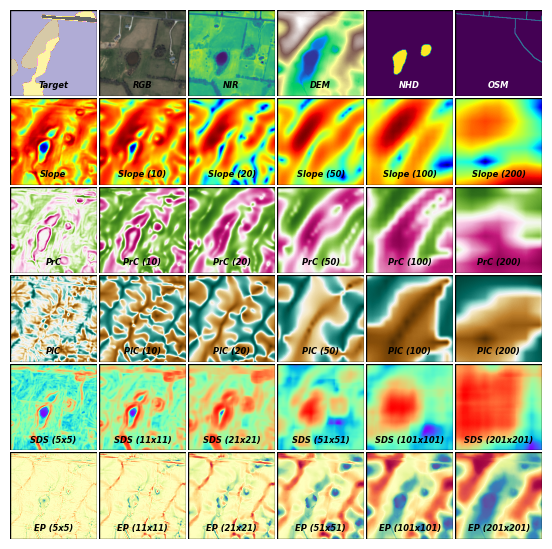

In [71]:

patches_dir = r'../data/patches_warren'

# random_patch = np.random.choice(patch_ids, 1).item()
# random_patch = np.random.choice(hardin_ids, 1).item()

# print(random_patch)
random_patch = '256_50_21983'

# prepare rgb or nir+gb (false color) image
rgb_image = []
for image in [f"{patches_dir}/{random_patch}_aerialr.tif", f"{patches_dir}/{random_patch}_aerialg.tif", f"{patches_dir}/{random_patch}_aerialb.tif"]:
    with rasterio.open(image) as src:
        data = src.read(1)
        rgb_image.append(data)
rgb_image = np.dstack(rgb_image) / 255


# plot images...
images_per_row = 6
subplot_width = 6.875 / images_per_row  
subplot_height = 6.875 / images_per_row 
fig, ax = plt.subplots(nrows=6, ncols=images_per_row, figsize=(images_per_row * subplot_width, 6 * subplot_height))
plt.subplots_adjust(hspace=0.02, wspace=0.02)
ax = ax.ravel()

# plot geology mask...
with rasterio.open(f"{patches_dir}/{random_patch}_geology.tif") as src:
    show(src, ax=ax[0], cmap=cmap, vmin=1, vmax=7)

# plot rgb or nir+gb...
ax[1].imshow(rgb_image)

# plot additional images...
additional = ['aerialnir.tif', 'dem.tif', 
              'nhd.tif', 'osm.tif',
              'logslope.tif', 'logslope_10.tif', 'logslope_20.tif', 'logslope_50.tif', 'logslope_100.tif', 'logslope_200.tif',
              'procurv.tif', 'procurv_10.tif', 'procurv_20.tif', 'procurv_50.tif', 'procurv_100.tif', 'procurv_200.tif',
              'plancurv.tif', 'plancurv_10.tif', 'plancurv_20.tif', 'plancurv_50.tif', 'plancurv_100.tif', 'plancurv_200.tif',
              'logstdslope_dw5.tif', 'logstdslope_dw11.tif', 'logstdslope_dw21.tif', 'logstdslope_dw51.tif', 'logstdslope_dw101.tif', 'logstdslope_dw201.tif',
              'ep_5x5.tif', 'ep_11x11.tif', 'ep_21x21.tif', 'ep_51x51.tif', 'ep_101x101.tif', 'ep_201x201.tif']

color_maps = ['viridis', 'terrain', 
              'viridis', 'viridis',
              'jet', 'jet', 'jet', 'jet', 'jet', 'jet',
              'PiYG', 'PiYG', 'PiYG', 'PiYG', 'PiYG', 'PiYG', 
              'BrBG', 'BrBG', 'BrBG', 'BrBG', 'BrBG', 'BrBG', 
              'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 'rainbow', 
              'Spectral_r', 'Spectral_r', 'Spectral_r', 'Spectral_r', 'Spectral_r', 'Spectral_r', ]

for idx, (image, cmap2) in enumerate(zip(additional, color_maps), start=2):

    with rasterio.open(f"{patches_dir}/{random_patch}_{image}") as src:
        data = src.read(1)
        im = ax[idx].imshow(data, cmap=cmap2)

# plot labels...
for idx, title in enumerate(['Target', 'RGB', 'NIR', 'DEM', 
                             'NHD', 'OSM', 
                             'Slope', 'Slope (10)', 'Slope (20)', 'Slope (50)', 'Slope (100)', 'Slope (200)', 
                             'PrC', 'PrC (10)', 'PrC (20)', 'PrC (50)', 'PrC (100)', 'PrC (200)', 
                             'PlC', 'PlC (10)', 'PlC (20)', 'PlC (50)', 'PlC (100)', 'PlC (200)', 
                             'SDS (5x5)', 'SDS (11x11)', 'SDS (21x21)', 'SDS (51x51)', 'SDS (101x101)', 'SDS (201x201)', 
                             'EP (5x5)', 'EP (11x11)', 'EP (21x21)', 'EP (51x51)', 'EP (101x101)', 'EP (201x201)'], 
                             start=0):
    ax[idx].set_title(title, style='italic', weight='bold', size=6, y=0.0)
    if (idx==4) or (idx==5):
        ax[idx].set_title(title, style='italic', weight='bold', size=6, y=0.0, color='white')



for axes in ax:
    axes.set_axis_off()
    rect = patches.Rectangle((0, 0), 1, 1, transform=axes.transAxes, linewidth=1, edgecolor='black', facecolor='none')
    axes.add_patch(rect)

plt.savefig(f'../data/warren_{random_patch}_modalities.jpg', dpi=500, bbox_inches='tight')
plt.show()

# **Class Distributions**

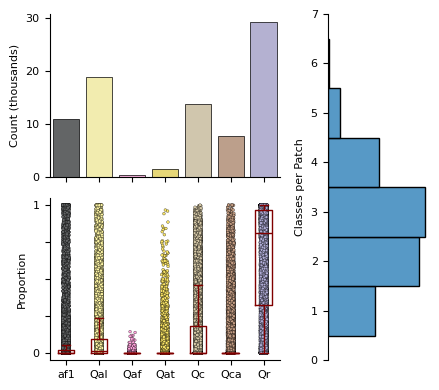

In [15]:
# Set up the figure and specify it as square
fig = plt.figure(figsize=(4.5, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[2.25,1], figure=fig)

# occurrence plot...
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(ax=ax1, data=counts, x=counts.index, y=0, hue=counts.index, palette=colors, edgecolor='k', linewidth=0.5)
ax1.set_xlabel('')
ax1.set_ylabel('Count (thousands)', size=8)
ax1.set_yticks([0, 10000, 20000, 30000])
ax1.set_yticklabels(['0', '10', '20', '30'], size=8)

# area plot...
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
# sns.histplot(ax=ax2, data=df_areas_longform, x='Geologic Map Unit', y='Proportion')
sns.boxplot(ax=ax2, data=df_areas_longform, x='Geologic Map Unit', y='Proportion', 
            showfliers=False, fill=False, color='#800000', width=0.5, linewidth=1)
sns.stripplot(ax=ax2, data=df_areas_longform, x='Geologic Map Unit', y='Proportion', hue='Geologic Map Unit', 
              palette=colors, alpha=1, zorder=0, linewidth=0.2, edgecolor='k', s=2)
ax2.set_xlabel('')
ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticklabels(), size=8)
ax2.set_ylabel('Proportion', size=8)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax2.set_yticklabels(['0', '', '', '', '1'], size=8)

# patch label plot...
ax3 = fig.add_subplot(gs[:, 1])
patch_counts = df_counts.iloc[:, 1:].sum(axis=1)
sns.histplot(ax=ax3, y=patch_counts, discrete=True)
ax3.set_xlabel('')
ax3.set_ylabel('Classes per Patch', size=8, rotation=90)
ax3.set_yticks(ax3.get_yticks())
ax3.set_yticklabels(ax3.get_yticklabels(), size=8)
ax3.set_xticks([])

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.set_facecolor('#e3e3e3')
    # ax.grid(axis='y', color='k', linestyle='-', linewidth=0.25)

ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax1.tick_params(labelbottom=False)

plt.tight_layout()

fig.savefig(r'../data/patch_stats.jpg', dpi=500)

plt.show()


In [ ]:
for x in df_areas.iloc[:, 1:]:
    fig, ax = plt.subplots(figsize=(5,5))
    sns.histplot(ax=ax, data=df_areas, x=x, bins=10, stat='percent')
    ax.set_title(x)
    plt.savefig(f'../data/area_hist_{x}.jpg', dpi=500)


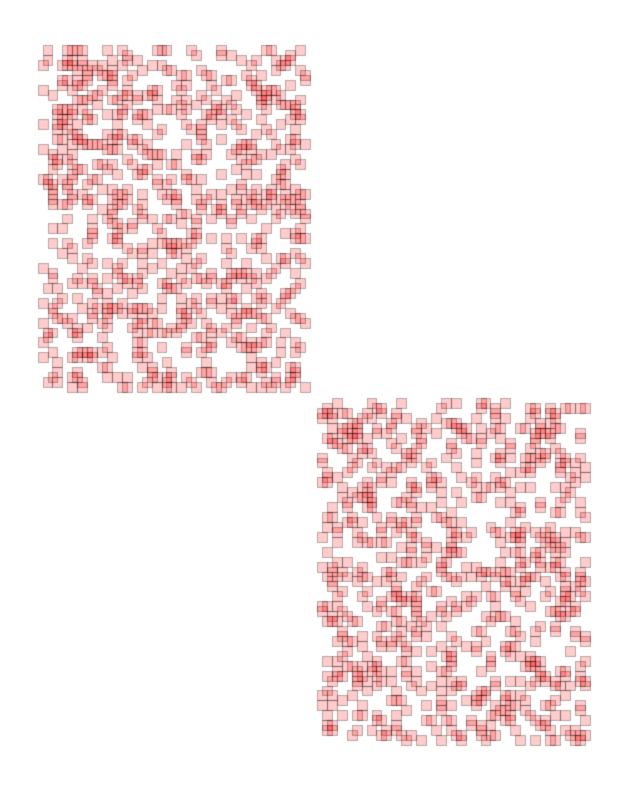

In [82]:
fig, ax = plt.subplots(figsize=(10,10))

gdf_hardin.plot(ax=ax, facecolor='red', edgecolor='k', linewidth=1, alpha=0.2,)

ax.set_axis_off()

plt.savefig(r'../models/patches/hardin_patches.jpg', dpi=500)

plt.show()

In [95]:
warren_train_path = r'../models/patches/warren_patches_train.geojson'
warren_val_path = r'../models/patches/warren_patches_val.geojson'
warren_test_path = r'../models/patches/warren_patches_test.geojson'
hardin_test_path = r'../models/patches/hardin_patches_test.geojson'

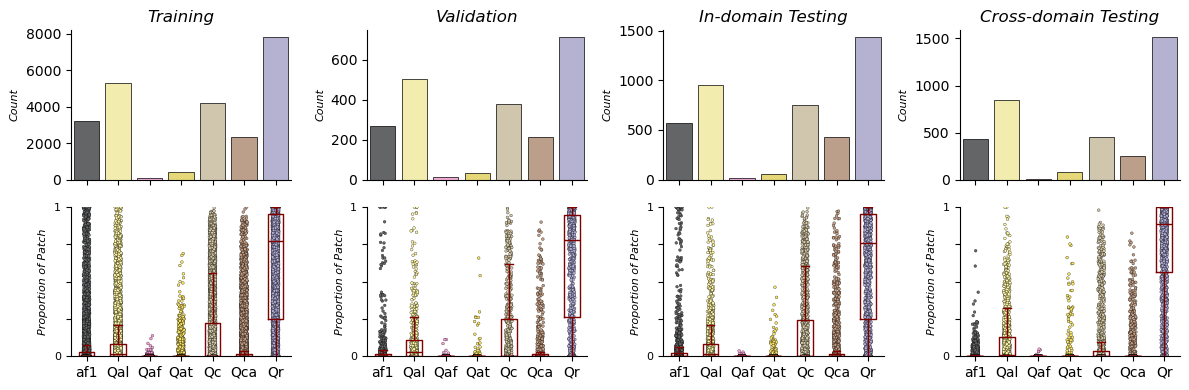

In [118]:

all_counts_path = r'../data/all_counts.csv'
df_counts = pd.read_csv(all_counts_path)

all_areas_path = r'../data/all_areas.csv'
df_areas = pd.read_csv(all_areas_path)

train_paths = [warren_train_path, warren_val_path, warren_test_path, hardin_test_path]


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
ax = ax.ravel()
plt.subplots_adjust(wspace=0.2)
idx1 = 0
idx2 = 4

for path, name in zip(train_paths, ['Training', 'Validation', 'In-domain Testing', 'Cross-domain Testing']):
    gdf = gpd.read_file(path)
    id_list = gdf['patch_id'].to_list()

    counts = df_counts[df_counts['patch_id'].isin(id_list)]
    counts = counts.iloc[:, 1:].sum(axis=0)
    counts = pd.DataFrame(counts)
    
    areas = df_areas[df_areas['patch_id'].isin(id_list)].iloc[:, 1:]
    areas_long = areas.melt(var_name='Geologic Map Unit', value_name='Proportion')


    sns.barplot(ax=ax[idx1], data=counts, x=counts.index, y=0, hue=counts.index, palette=colors, edgecolor='k', linewidth=0.5)
    ax[idx1].set_xlabel('')
    ax[idx1].set_ylabel('Count', size=8, style='italic')


    sns.boxplot(ax=ax[idx2], data=areas_long, x='Geologic Map Unit', y='Proportion', 
            showfliers=False, fill=False, color='#800000', width=0.5, linewidth=1)
    sns.stripplot(ax=ax[idx2], data=areas_long, x='Geologic Map Unit', y='Proportion', hue='Geologic Map Unit', 
                palette=colors, alpha=1, zorder=0, linewidth=0.2, edgecolor='k', s=2)
    ax[idx2].set_xlabel('')
    ax[idx2].set_ylabel('Proportion of Patch', size=8, style='italic')
    ax[idx2].set_ylim(0,1)
    ax[idx2].set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax[idx2].set_yticklabels(['0', '', '', '', '1'], size=8)


    ax[idx1].set_title(name, style='italic')
    ax[idx1].spines['top'].set_visible(False)
    ax[idx1].spines['right'].set_visible(False)
    ax[idx1].tick_params(labelbottom=False)

    ax[idx2].spines['top'].set_visible(False)
    ax[idx2].spines['right'].set_visible(False)


    idx1 += 1
    idx2 += 1

plt.tight_layout()
plt.savefig(r'../data/distributions.jpg', dpi=500)
plt.show()

In [151]:
[round(x-y, 3) for x,y in zip(in_auc_ep, cross_auc_ep)]

[-0.012, 0.085, 0.056, 0.144, 0.205, 0.046, 0.025]

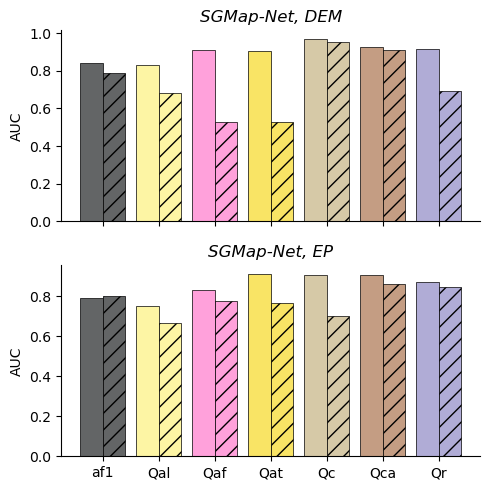

In [146]:
classes = ['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']

# dem
in_auc_dem = [0.841, 0.829, 0.912, 0.904, 0.967, 0.925, 0.915]
cross_auc_dem = [0.786, 0.683, 0.528, 0.529, 0.955, 0.913, 0.695]

# ep
in_auc_ep = [0.789, 0.749, 0.830, 0.909, 0.907, 0.907, 0.873]
cross_auc_ep = [0.801, 0.664, 0.774, 0.765, 0.702, 0.861, 0.848]

colors = {'af1': '#636566', 
          'Qal': '#fdf5a4', 
          'Qaf': '#ffa1db', 
          'Qat': '#f9e465', 
          'Qc': '#d6c9a7', 
          'Qca': '#c49d83', 
          'Qr': '#b0acd6'}


fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(5,5))
plt.subplots_adjust(hspace=0.2)
ax = ax.ravel()

x = np.arange(len(classes))
bar_width=0.4

ax[0].bar(x-bar_width / 2, in_auc_dem, bar_width, color=[colors[c] for c in classes], linewidth=0.5, edgecolor='k', label='In-domain')
ax[0].bar(x+bar_width / 2, cross_auc_dem, bar_width, color=[colors[c] for c in classes], linewidth=0.5, edgecolor='k', hatch='//', label='Cross-domain')

ax[0].set_title('SGMap-Net, DEM', style='italic')
ax[0].set_ylabel('AUC')
ax[0].set_xticks(x)
ax[0].set_xticklabels(classes) 
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)



ax[1].bar(x-bar_width / 2, in_auc_ep, bar_width, color=[colors[c] for c in classes], linewidth=0.5, edgecolor='k', label='In-domain')
ax[1].bar(x+bar_width / 2, cross_auc_ep, bar_width, color=[colors[c] for c in classes], linewidth=0.5, edgecolor='k', hatch='//', label='Cross-domain')

ax[1].set_title('SGMap-Net, EP', style='italic')
ax[1].set_ylabel('AUC')
ax[1].set_xticks(x)
ax[1].set_xticklabels(classes) 
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)


plt.tight_layout()
plt.savefig(r'../models/in_cross_comparison.jpg', dpi=500)
plt.show()